In [ ]:
! pip install -q transformers

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
train_df = pd.read_csv("train_data.csv")
valid_df = pd.read_csv("valid_data.csv")
test_df = pd.read_csv('test_data.csv')

In [ ]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',return_dict=False)

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.sentence = dataframe.Sentence
        self.targets = self.data.Sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.sentence)

    def __getitem__(self, index):
        sentence = str(self.sentence[index])
        sentence = " ".join(sentence.split())

        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
training_set = CustomDataset(train_df, tokenizer, MAX_LEN)
validation_set = CustomDataset(valid_df, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_df, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
valid_loader = DataLoader(validation_set, **test_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 3)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids,return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
train_epoch_loss = []
valid_epoch_loss = []

def train_and_eval(epoch):
    for i in range(0,epoch):
      model.eval()
      loss_valid = 0
      with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].type(torch.LongTensor)
            targets = targets.to(device)
            outputs = model(ids, mask, token_type_ids)
            loss_valid += loss_fn(outputs, targets).item()

      valid_epoch_loss.append(loss_valid)
      if epoch>0:
        if loss_valid < valid_epoch_loss[-1]:
          torch.save(model.state_dict(),'bert_train')

      model.train()
      loss_train = 0
      for _,data in enumerate(training_loader, 0):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.long)
          outputs = model(ids, mask, token_type_ids)
          loss = loss_fn(outputs, targets)
          loss_train += loss.item()

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      train_epoch_loss.append(loss_train)
      print(i)

In [ ]:
train_and_eval(5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0
1
2
3
4


In [ ]:
train_epoch_loss

[339.67900647222996,
 178.28855255246162,
 104.85553687810898,
 61.66679632337764,
 39.95816018618643]

In [ ]:
valid_epoch_loss

[117.76911741495132,
 52.69640149176121,
 45.985498029738665,
 44.95017610164359,
 57.52719500125386]

<Axes: xlabel='epoch', ylabel='loss'>

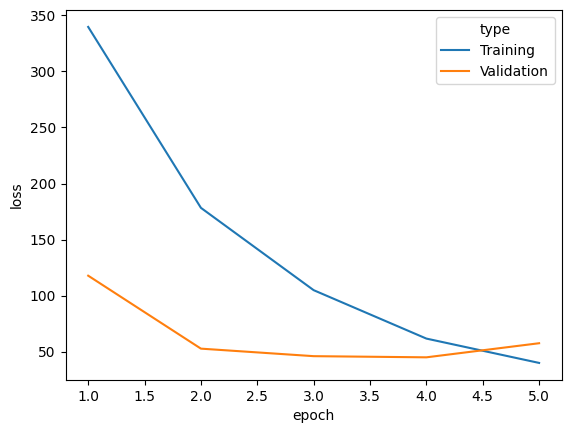

In [ ]:
train_loss = pd.DataFrame({'type':'Training','loss':train_epoch_loss,'epoch':range(1,6)})
valid_loss = pd.DataFrame({'type':'Validation','loss':valid_epoch_loss,'epoch':range(1,6)})
loss_df = pd.concat([train_loss,valid_loss],axis=0)
sns.lineplot(x = 'epoch',y='loss',hue='type',data=loss_df)

In [ ]:
# retrain model to best epoch with training and validation data

final_train_df = pd.concat([train_df,valid_df],axis=0)
final_train_df = final_train_df.reset_index(drop=True)
final_training_set = CustomDataset(final_train_df, tokenizer, MAX_LEN)
final_training_loader = DataLoader(final_training_set, **train_params)



model2 = BERTClass()
model2.to(device)
optimizer = torch.optim.Adam(params =  model2.parameters(), lr=LEARNING_RATE)

epoch_loss = []
def train(epoch):
    for i in range(0,epoch):
      loss_train = 0
      for _,data in enumerate(final_training_loader, 0):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.long)
          outputs = model2(ids, mask, token_type_ids)
          loss = loss_fn(outputs, targets)
          loss_train += loss.item()
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      print(i)
      epoch_loss.append(loss_train)

train(4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, 

0
1
2
3


In [ ]:
epoch_loss

[342.6740256920457, 155.75602408125997, 69.9907545526512, 35.153281963663176]

In [ ]:
model2.eval()
fin_targets=[]
fin_outputs=[]
with torch.no_grad():
    for _, data in enumerate(testing_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model2(ids, mask, token_type_ids)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(outputs.argmax(dim=1).cpu().detach().numpy().tolist())


In [ ]:
pd.Series(fin_outputs).value_counts()

1    664
2    321
0     79
dtype: int64

In [ ]:
res = fin_outputs

In [ ]:
accuracy = metrics.accuracy_score(fin_targets, res)
f1_score_micro = metrics.f1_score(fin_targets, res, average='micro')
f1_score_macro = metrics.f1_score(fin_targets, res, average='macro')
precision_micro = metrics.precision_score(fin_targets, res,average='micro')
precision_macro = metrics.precision_score(fin_targets, res,average='macro')
recall_micro = metrics.recall_score(fin_targets, res,average='micro')
recall_macro = metrics.recall_score(fin_targets, res,average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"Precision (Micro) = {precision_micro}")
print(f"Precision (Macro) = {precision_macro}")
print(f"Recall (Micro) = {recall_micro}")
print(f"Recall (Macro) = {recall_macro}")

Accuracy Score = 0.8270676691729323
F1 Score (Micro) = 0.8270676691729322
F1 Score (Macro) = 0.7564091308050607
Precision (Micro) = 0.8270676691729323
Precision (Macro) = 0.7979916828083659
Recall (Micro) = 0.8270676691729323
Recall (Macro) = 0.7306215078255623


In [ ]:
torch.save(model.state_dict(),'bert_1')

In [ ]:
#Test the predictions
pred_sentence = 'Apple announces 90% profit'
pred_df = pd.DataFrame({'sentence':[pred_sentence]})
pred_df

,sentence
0,Apple announces 90% profit


In [ ]:
class PredDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.sentence = dataframe.sentence
        self.max_len = max_len

    def __len__(self):
        return len(self.sentence)

    def __getitem__(self, index):
        sentence = str(self.sentence[index])
        sentence = " ".join(sentence.split())

        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        }

In [ ]:
pred_params = {'batch_size': 1,
                'shuffle': True,
                'num_workers': 0
                }
pred_set = PredDataset(pred_df, tokenizer, MAX_LEN)
pred_loader = DataLoader(pred_set, **pred_params)

In [ ]:
model2.eval()
res = []
with torch.no_grad():
    for _, data in enumerate(pred_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        outputs = model2(ids, mask, token_type_ids)
        res.append(outputs.argmax(dim=1).cpu().detach().numpy().tolist())

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
res

[[2]]

In [ ]:
model.load_state_dict(torch.load('bert_1'))


<All keys matched successfully>